In [1]:
from pydlr import kernel, dlr
from triqs.gf import *
from h5 import HDFArchive
import numpy as np
np.random.seed(85281)

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

import matplotlib.pyplot as plt
plt.style.use('publish')

In [2]:
class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #if complex: g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa
    
    def get_x_l(self, g_xaa):
        x_l = g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]].flatten()
        return x_l
    
    def set_x_l(self, g_xaa, x_l):
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = x_l.reshape((self.nx, self.N))
        return g_xaa
        

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs

In [35]:
def constrained_lstsq_dlr_from_tau(d,         # dlr class
                                   tau,       # tau mesh
                                   g_iaa,     # G data
                                   g0_iaa,    # G0 data
                                   beta,      # inverse temperature
                                   sigma_moments, # high-freq moments of Σ
                                   method = {'norm': 'iw',  # norm -> { 'tau', 'iw'}
                                             'optim': 'dlr', # optim -> { 'dlr', 'sigma'}
                                            }, # driver for different settings
                                   ftol=1e-9, 
                                   symmetrizer=None,
                                   verbose = True,
                                   minimal_dlr=False,
                                   initial_sigma=None
                                  ):
    
    
    
    
    
    nx = len(d)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    dtype = complex
    nX = nx * (no + 2*N)
    
    # precompute Mkl
    def compute_mkl(d):
        Mkl = np.zeros((len(d), len(d)), dtype=np.float128)
        for iwk, wk in enumerate(d.dlrrf):
            for iwl, wl in enumerate(d.dlrrf):
                K0wk, Kbwk = kernel(np.array([0.,1.]), np.array([wk]))
                K0wl, Kbwl = kernel(np.array([0.,1.]), np.array([wl]))
                if np.fabs(wk+wl) < 1e-13:
                    Mkl[iwk,iwl] = K0wk*K0wl
                else:
                    Mkl[iwk, iwl] = (K0wk*K0wl - Kbwk*Kbwl)
                    Mkl[iwk, iwl] /= ((wk+wl))
        return Mkl
    
    # fold and unfold complex numbers
    
    def merge_re_im(x):
        x_d, x_u = x[:nx*no], x[nx*no:]
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        return x_d, x_u

    def split_re_im(x_d, x_u):
        return np.concatenate((
            np.array(x_d.real, dtype=float),
            np.array(x_u.real, dtype=float),
            np.array(x_u.imag, dtype=float)))
                                   
    # Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x
    
    def sig_from_x(x):
        x_d, x_off = x[:2*nx*no], x[2*nx*no:]
        x_u, x_l = np.split(x_off, 2)
    
        re, im = np.split(x_d, 2)
        x_d = re + 1.j * im
        
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        
        re, im = np.split(x_l, 2)
        x_l = re + 1.j * im
        
        sig = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(sig, x_u)
        sym.set_x_l(sig, x_l)
        sym.set_x_d(sig, x_d)
        
        return sig

    def x_from_sig(sig):
        x_d = sym.get_x_d(sig);
        x_u = sym.get_x_u(sig);
        x_l = sym.get_x_l(sig);
        x = np.concatenate((np.array(x_d.real, dtype=float),
                        np.array(x_d.imag, dtype=float),
                        np.array(x_u.real, dtype=float),
                        np.array(x_u.imag, dtype=float),
                        np.array(x_l.real, dtype=float),
                        np.array(x_l.imag, dtype=float)
                      ))
    
        return x
    
    
    # constraint
    sig_infty, sigma_1 = sigma_moments[0], sigma_moments[1]
        
    def mat_vec(mat):
        v_d = sym.get_x_d(mat[None, ...])
        v_u = sym.get_x_u(mat[None, ...])
        v_l = sym.get_x_l(mat[None, ...])
        
        return np.concatenate((
            np.array(v_d.real, dtype=float),
            np.array(v_d.imag, dtype=float),
            np.array(v_u.real, dtype=float),
            np.array(v_u.imag, dtype=float),
            np.array(v_l.real, dtype=float),
            np.array(v_l.imag, dtype=float)
        ))
        
    def constraint_func(x):
    
        if method['optim'] == 'sigma':
            sig = d.dlr_from_matsubara(sig_from_x(x), beta)
            mat = -sig.sum(axis=0)
        else:
            sig = sig_from_x(x)
            mat = -sig.sum(axis=0)
            
        vec = mat_vec(mat)
        return vec
    
    bound = mat_vec(sigma_1)
    
    constraints = (NonlinearConstraint(constraint_func,
                                           bound, bound))


    # target function   
    def dyson_difference(x):
        
        if method['optim'] == 'sigma':
            sig = sig_from_x(x)
        else:
            sig = d.matsubara_from_dlr(sig_from_x(x), beta)
        
        sig_iwaa = sig + sig_infty
            
        #  G - G0 - G0*Σ*G = 0 done on the DLR nodes
        r_iwaa = g_iwaa - g0_iwaa - g0_iwaa@sig_iwaa@g_iwaa
        
        if method['norm'] == 'tau':
            # compute DLR of rk_iwaa
            #r_xaa = d.lstsq_dlr_from_matsubara(freq, r_iwaa, beta)
            r_xaa = d.dlr_from_matsubara(r_iwaa, beta)
            # ||R||^2 = r^T @ M @ r
            #R2 = np.einsum('nmk, kl, lnm->nm', r_xaa.T.conj(), Mkl, r_xaa).flatten()
            R2 = np.einsum('mnk, kl, lnm->nm', r_xaa.T.conj(), Mkl, r_xaa).flatten()
            return np.sqrt(np.sum(R2)).real
        else:
            return np.linalg.norm(r_iwaa.flatten())
        
    def target_function(x):
        y = dyson_difference(x)
        return y 
        
    if method['norm'] == 'tau':
        # compute Mkl
        Mkl = compute_mkl(d)
        
    freq = d.get_matsubara_frequencies(beta)
    
    # dlr fit to G and G0
    if minimal_dlr:
        triqs_freq = np.array([complex(x) for x in tau]) # here tau is triqs iomega_n
        dlr_indices = np.array([np.where(abs(triqs_freq-f) < 1e-8)[0][0] for f in freq])
        g_iwaa, g0_iwaa = g_iaa[dlr_indices], g0_iaa[dlr_indices]
        
    else:
        g_xaa = d.lstsq_dlr_from_tau(tau, g_iaa, beta)
        g0_xaa = d.lstsq_dlr_from_tau(tau, g0_iaa, beta)
        # compute and obtain initial Σ
        g_iwaa = d.matsubara_from_dlr(g_xaa, beta)
        g0_iwaa = d.matsubara_from_dlr(g0_xaa, beta)
    
    if verbose and not minimal_dlr:
        g=d.eval_dlr_tau(g_xaa, tau, beta)
        g0=d.eval_dlr_tau(g0_xaa, tau,  beta)
        
        print('initial DLR fits to G(τ) and G0(τ)')
        print(f'|G(τ) - Gdlr(τ)| = {np.max(np.abs(g-g_iaa)):.6e}')
        print(f'|G0(τ) - G0dlr(τ)| = {np.max(np.abs(g0-g0_iaa)):.6e}')
    
    # the DLR representable part of the self-energy
    if initial_sigma is None:
        sig0_iwaa = np.linalg.inv(g0_iwaa)-np.linalg.inv(g_iwaa)-sig_infty
    else:
        sig0_iwaa = initial_sigma
    
    if verbose:
        check = sig_from_x(x_from_sig(sig0_iwaa))
        assert np.allclose(check, sig0_iwaa), "sigma converter is broken!"
    
    if method['optim'] == 'sigma': 
        # optimize Σ(iν)
        x_init = x_from_sig(sig0_iwaa)
    else:
        # optimize σ -> Σ(iν) = Aσ + Σoo
        x_init = x_from_sig(d.dlr_from_matsubara(sig0_iwaa, beta))
    
    sol = minimize(target_function, 
                   x_init,
                   method='SLSQP', 
                   constraints=constraints,
                   options=dict(ftol=ftol, 
                                maxiter=10000, 
                                disp=True),
        )
    
    print(sol.success, sol.message)
    
    if method['optim'] == 'sigma':
        sig_iwaa = sig_from_x(sol.x)
        sig_xaa = d.dlr_from_matsubara(sig_iwaa, beta)
    else:
        sig_xaa = sig_from_x(sol.x)
        
    print(f'Σ1 constraint diff: {np.max(np.abs(-sig_xaa.sum(axis=0)-sigma_1)):.4e}')

    return sig_xaa, sol

## Hubbard Atom

Consider a Hubbard atom. The non-interacting and interacting Green's functions are

$$ G_{0}(i\omega_{n}) = \frac{1}{i\omega_{n} + U/2}$$
$$ G(i\omega_{n}) = \frac{1}{2(i\omega_{n} + U/2)} + \frac{1}{2(i\omega_{n} - U/2)} $$

The self-energy

$$ \Sigma = G_{0}^{-1} - G^{-1}, $$
is then 
$$ \Sigma (i\omega_{n}) = \frac{U}{2} + \frac{U^{2}}{4 i\omega_{n}} $$

In [37]:
beta = 10
U    = 2

iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=100)

G0_iw = Gf(mesh=iw_mesh, target_shape=[1,1])
G0_iw << inverse(iOmega_n + U/2)

G0_tau = make_gf_from_fourier(G0_iw)

G_iw  = Gf(mesh=iw_mesh, target_shape=[1,1])
G_iw  << inverse(2*(iOmega_n + U/2)) + inverse(2*(iOmega_n - U/2))

G_tau = make_gf_from_fourier(G_iw)

G_tau_qmc = G_tau.copy()

tol = 1e-4
G_tau_qmc.data[:] += np.random.normal(scale=tol, size=G_tau_qmc.data.shape)
G_iw_qmc = make_gf_from_fourier(G_tau_qmc)

Sigma_iw = G_iw.copy()
Sigma_iw << U/2 + 0.25*U*U*inverse(iOmega_n)

Greens Function  with mesh Matsubara Freq Mesh of size 200, Domain: Matsubara domain with beta = 10, statistic = Fermion, positive_only : 0 and target_shape (1, 1): 

In [38]:
Sigma_iw_num = inverse(G0_iw)-inverse(G_iw)
Sigma_iw_qmc = inverse(G0_iw)-inverse(G_iw_qmc)

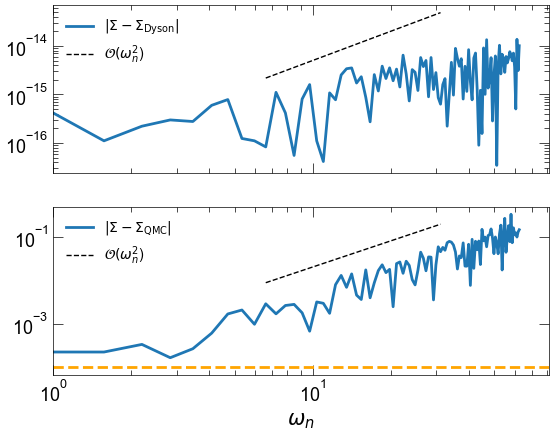

In [39]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].loglog(iw.imag, np.abs(Sigma_iw_num.data[:,0,0]-Sigma_iw.data[:,0,0]),label='$|\Sigma-\Sigma_{\mathrm{Dyson}}|$')
ax[0].loglog(iw.imag[110:150], (5e-17*iw.imag[110:150]**2), 'k--', lw=1, label=r'$\mathcal{O}(\omega_{n}^{2}$)')
ax[-1].set_xlim(1,)
ax[0].legend()
ax[1].loglog(iw.imag, np.abs(Sigma_iw_qmc.data[:,0,0]-Sigma_iw.data[:,0,0]),label='$|\Sigma-\Sigma_{\mathrm{QMC}}|$')
ax[1].loglog(iw.imag[110:150], (2*tol*iw.imag[110:150]**2), 'k--', lw=1, label=r'$\mathcal{O}(\omega_{n}^{2}$)')
ax[1].axhline(tol, ls='--', color='orange')
ax[1].legend()
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

In [11]:
triqs_freq = np.array([complex(x) for x in Sigma_iw_num.mesh])
dlr_matsubara_freq = d.get_matsubara_frequencies(10)

In [56]:
import scipy.integrate

In [ ]:
scipy.integrate.

In [58]:
scipy.integrate.simpson(np.linalg.norm((G_tau_qmc.data-G0_tau.data), axis=(tuple(range(1, G0_tau.data.ndim)))),tau_i)

0.9865082627433774

In [30]:
dlr_indices = np.array([np.where(abs(triqs_freq-freq) < 1e-8)[0][0] for freq in dlr_matsubara_freq])
triqs_freq[dlr_indices], dlr_matsubara_freq

(array([0.-12.88052988j, 0. -8.48230016j, 0. -5.96902604j, 0. -4.71238898j,
        0. -4.08407045j, 0. -3.45575192j, 0. -2.82743339j, 0. -2.19911486j,
        0. -1.57079633j, 0. -0.9424778j , 0. -0.31415927j, 0. +0.31415927j,
        0. +0.9424778j , 0. +1.57079633j, 0. +2.19911486j, 0. +2.82743339j,
        0. +3.45575192j, 0. +4.08407045j, 0. +5.34070751j, 0. +7.2256631j ,
        0.+13.50884841j, 0.+19.16371519j]),
 array([-0.-12.88052988j, -0. -8.48230016j, -0. -5.96902604j,
        -0. -4.71238898j, -0. -4.08407045j, -0. -3.45575192j,
        -0. -2.82743339j, -0. -2.19911486j, -0. -1.57079633j,
        -0. -0.9424778j , -0. -0.31415927j,  0. +0.31415927j,
         0. +0.9424778j ,  0. +1.57079633j,  0. +2.19911486j,
         0. +2.82743339j,  0. +3.45575192j,  0. +4.08407045j,
         0. +5.34070751j,  0. +7.2256631j ,  0.+13.50884841j,
         0.+19.16371519j]))

In [40]:
d = dlr(lamb=30, eps=1e-9)
tau_i = np.array([float(x) for x in G_tau_qmc.mesh])
iw_i  = np.array([complex(x) for x in G0_iw.mesh])
sigma_moments=np.array([U/2, 0.25*U*U],dtype=complex)
methods = [#{'norm': 'iw', 'optim': 'dlr'},
           #{'norm': 'iw', 'optim': 'sigma'},
           #{'norm': 'tau', 'optim': 'dlr'},
           {'norm': 'tau', 'optim': 'sigma'}
          ]

Sigma_iw_fit = [None]*len(methods)
for im, method in enumerate(methods):
    print('Method: optimize = {}, norm = {}'.format(method['optim'], method['norm']))
    sig_xaa, sol = constrained_lstsq_dlr_from_tau(d,
                                   iw_i,    
                                   #G_tau_qmc.data,
                                   G_iw_qmc.data,
                                   #G0_tau.data,
                                   G0_iw.data,
                                   beta, 
                                   sigma_moments.reshape(-1,1,1),
                                   method = method, 
                                   ftol=1e-6,
                                   minimal_dlr=True)
    Sigma_iw_fit[im] = Sigma_iw.copy()
    Sigma_iw_fit[im].data[:] = d.eval_dlr_freq(sig_xaa, iw, beta) +sigma_moments[0]
    print('\n')

Method: optimize = sigma, norm = tau
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3782391617603874615e-05
            Iterations: 42
            Function evaluations: 1652
            Gradient evaluations: 42
True Optimization terminated successfully
Σ1 constraint diff: 2.8133e-07




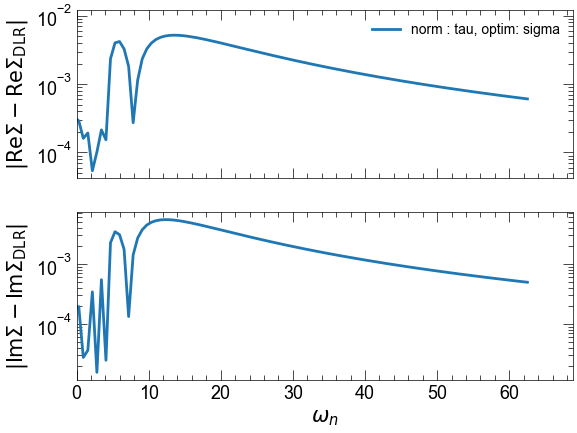

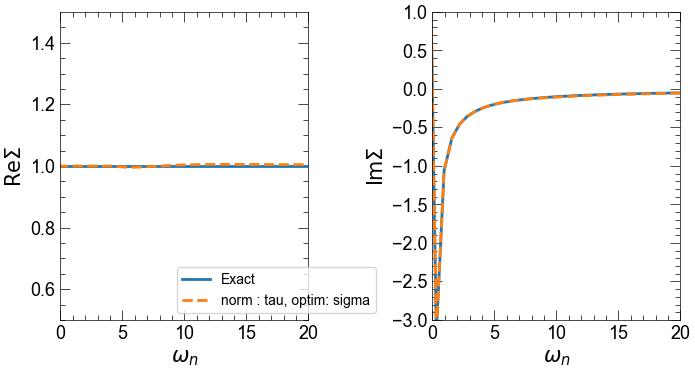

In [41]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
for method, sigma in zip(methods, Sigma_iw_fit):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    ax[0].semilogy(iw.imag, np.abs(sigma.data[:,0,0].real-Sigma_iw.data[:,0,0].real),label=label)
    ax[1].semilogy(iw.imag, np.abs(sigma.data[:,0,0].imag-Sigma_iw.data[:,0,0].imag))

ax[0].legend()
ax[0].set_xlim(0,)
ax[0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_xlim(0,)
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8,4))
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].plot(iw.imag, Sigma_iw.data[:,0,0].real,label='Exact')
ax[1].plot(iw.imag, Sigma_iw.data[:,0,0].imag)

for method, sigma,ls in zip(methods, Sigma_iw_fit, ['--', '-.', ':', '-']):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    ax[0].plot(iw.imag, sigma.data[:,0,0].real,ls=ls,label=label)
    ax[1].plot(iw.imag, sigma.data[:,0,0].imag, ls=ls)

ax[0].legend(frameon=True, loc='lower right',bbox_to_anchor=(1.3, 0.))
ax[0].set_xlim(0,20); ax[0].set_ylim(1/2, 3/2)
ax[0].set_ylabel('$\mathrm{Re}\Sigma$')
ax[1].set_ylabel('$\mathrm{Im}\Sigma$')
ax[1].set_xlim(0,20); ax[1].set_ylim(-3, 1)
ax[0].set_xlabel(r'$\omega_{n}$'); ax[1].set_xlabel(r'$\omega_{n}$')
plt.subplots_adjust(wspace=0.5)
plt.show()

# Dimer

In [ ]:
from dimer import *
from common import *

In [ ]:
def dyson_solver(d, Sigma_iw_raw, G_tau, G0_tau, Sigma_moments, **kwargs):
    
    beta = G_tau.mesh.beta
    tau = np.array([float(x) for x in G_tau.mesh])
    
    Sigma_iw_fit = Sigma_iw_raw.copy()
    iw = np.array([complex(x) for x in Sigma_iw_fit.mesh])
    
    for block, sig in Sigma_iw_fit:
        sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                                      tau,
                                                      G_tau[block].data,
                                                      G0_tau[block].data, 
                                                      beta,
                                                      Sigma_moments[block],
                                                      **kwargs
                                                      )
        Sigma_iw_fit[block].data[:] = d.eval_dlr_freq(sig_xaa, iw, beta)
        Sigma_iw_fit[block].data[:] += Sigma_moments[block][0]
    return Sigma_iw_fit

In [ ]:
#tau_i = np.array([float(x) for x in G_tau_ref.mesh])
#iw_i = np.array([complex(x) for x in Sigma_iw_ref.mesh])
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
for block, _ in G_tau_qmc: G_tau_qmc[block].data[:] += np.random.normal(scale=tol, size=G_tau_qmc[block].data.shape)

d = dlr(lamb=30,eps=1e-6)
sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)

methods = [{'norm': 'iw', 'optim': 'dlr'},
           {'norm': 'tau', 'optim': 'dlr'},
           {'norm': 'iw', 'optim': 'sigma'},
           {'norm': 'tau', 'optim': 'sigma'}
          ]

Sigma_iw_raw = Sigma_iw_ref.copy()
Sigma_iw_raw.zero();

Sigma_iw_fit = [None]*len(methods)
for im, method in enumerate(methods):
    print('Method: optimize = {}, norm = {}'.format(method['optim'], method['norm']))
    Sigma_iw_fit[im] = dyson_solver(d, Sigma_iw_raw,
                                       G_tau_qmc, 
                                       G0_tau_ref, 
                                       sigma_moments,
                                       method=method, ftol=1e-6)
    print('\n')

In [ ]:
fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
for method, sigma in zip(methods, Sigma_iw_fit):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    iw_i = np.array([complex(x) for x in sigma.mesh])
    for i in range(2):
        for j in range(2):
            #ax[i,j].semilogy(iw_i.imag, np.abs(sigma['up'].data[:,i,j].real-Sigma_iw_ref['up'].data[:,i,j].real),label=label)
            ax[i,j].semilogy(iw_i.imag, np.abs(sigma['up'].data[:,i,j]-Sigma_iw_ref['up'].data[:,i,j]),label=label)

ax[0,0].legend()
ax[0,0].set_xlim(0,)
#ax[0,0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
#ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
#ax[0,1].set_xlim(0,)
#ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,4))
iw_i = np.array([complex(x) for x in Sigma_iw_ref.mesh])
for i in range(2):
    for j in range(2):
        #ax[i,j].plot(iw_i.imag, Sigma_iw_ref['up'].data[:,i,j].real,'k-', label='Exact')
        ax[i,j].plot(iw_i.imag, Sigma_iw_ref['up'].data[:,i,j].imag, 'k-',label='Exact')

for method, sigma,ls in zip(methods, Sigma_iw_fit, ['--', '-.', ':', '-']):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    for i in range(2):
        for j in range(2):
            #ax[i,j].plot(iw_i.imag, sigma['up'].data[:,i,j].real,ls=ls,label=label)
            ax[i,j].plot(iw_i.imag, sigma['up'].data[:,i,j].imag, ls=ls,label=label)
ax[0,0].legend(frameon=True, loc='lower right',bbox_to_anchor=(1.3, 0.))
ax[0,0].set_ylim(-0.03,0)
ax[0,0].set_xlim(0,60); #ax[0].set_ylim(1/2, 3/2)
#ax[0].set_ylabel('$\mathrm{Re}\Sigma$')
#ax[1].set_ylabel('$\mathrm{Im}\Sigma$')
#ax[1].set_xlim(0,60); #ax[1].set_ylim(-3, 1)
#ax[0].set_xlabel(r'$\omega_{n}$'); ax[1].set_xlabel(r'$\omega_{n}$')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(8,4))
iw_i = np.array([complex(x) for x in Sigma_iw_ref.mesh])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(iw_i.imag, Sigma_iw_ref['up'].data[:,i,j].real,'k-', label='Exact')
        #ax[i,j].plot(iw_i.imag, Sigma_iw_ref['up'].data[:,i,j].imag, 'k-',label='Exact')

for method, sigma,ls in zip(methods, Sigma_iw_fit, ['--', '-.', ':', '-']):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    for i in range(2):
        for j in range(2):
            ax[i,j].plot(iw_i.imag, sigma['up'].data[:,i,j].real,ls=ls,label=label)
            #ax[i,j].plot(iw_i.imag, sigma['up'].data[:,i,j].imag, ls=ls,label=label)
ax[0,0].legend(frameon=True, loc='lower right',bbox_to_anchor=(1.3, 0.))
#ax[0,0].set_ylim(-0.03,0)
ax[0,0].set_xlim(0,60); ax[0,0].set_ylim(0.45, 0.5); ax[1,1].set_ylim(0.45, 0.5)
#ax[0].set_ylabel('$\mathrm{Re}\Sigma$')
#ax[1].set_ylabel('$\mathrm{Im}\Sigma$')
#ax[1].set_xlim(0,60); #ax[1].set_ylim(-3, 1)
#ax[0].set_xlabel(r'$\omega_{n}$'); ax[1].set_xlabel(r'$\omega_{n}$')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [44]:
def foo(**kwargs):
    if kwargs['minimal_dlr']:
        print('yes')

In [45]:
foo(minimal_dlr=True)

yes


In [47]:
len(dlr(lamb=80, eps=1e-6))

16